# Yet another approach

Instead of estimating the derivative, which can cause propagation of errors during integration, simply compute the Delta above baseline for each similar set of samples in a leaf. and then average grouping by unique x.  Then we have a number of dots to plot above and below in a strip plot. That shows the variation in the average does not have problems of accumulated beta/slope error.

So tracking the deltas for each leaf and then averaging across leaves does a pretty good job but it seems to underestimate the education versus weight (slope -1.2).  I also tried subtracting the baseline and then creating a new giant meta-X that contained all leaf_x/leaf_y values from all trees and then doing a decision tree to get the new splits. It turns out that just doing a group by followed by mean does the same thing, at least four nice integer values of x. This also does not seem to get a strong enough curve for education versus weight.  The goal of this approach is to avoid the granularity issue of day of year versus temperature that looks like a sine wave.  Currently I have to launch a separate RF for each leaf that has the number of leaves beyond the threshold.

Maybe the answer is to combine this approach of using a second decision tree that estimates the slope from the values in each decision tree leaf using a linear model.  Nope. See next para.

Combining the x/y from various leaves and then doing a second model is not a good idea. It is destroying the relationship between the x/y within a leaf obtained by stratifying using the original RF. We must get a slope or a model on the elements in that leaf alone. Subtracting the baseline from each leaf and then merging x/y does not seem to work. Well, Not with same fidelity as computing a model for each leaf.

analogy is a bunch of buildings poking up through a cloud layer. we need to model the tip of the skyscraper above the cloud layer. the height of the cloud layer at that particular spot is the baseline contribution from all other features and the stuff above is the marginal contribution for this feature.

In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from mine.plot import *
from mine.ice import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [2]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n//2
    nwomen = n//2
    df['ID'] = range(100,100+n)
    df['sex'] = ['M']*nmen + ['F']*nwomen
    df.loc[df['sex']=='F','pregnant'] = np.random.randint(0,2,size=(nwomen,))
    df.loc[df['sex']=='M','pregnant'] = 0
    df.loc[df['sex']=='M','height'] = 5*12+8 + np.random.uniform(-7, +8, size=(nmen,))
    df.loc[df['sex']=='F','height'] = 5*12+5 + np.random.uniform(-4.5, +5, size=(nwomen,))
    df.loc[df['sex']=='M','education'] = 10 + np.random.randint(0,8,size=nmen)
    df.loc[df['sex']=='F','education'] = 12 + np.random.randint(0,8,size=nwomen)
    df['weight'] = 120 \
                   + (df['height']-df['height'].min()) * 10 \
                   + df['pregnant']*10 \
                   - df['education']*1.2
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    return df

In [163]:
df_raw = toy_weight_data(200)
df = df_raw.copy()
catencoders = df_string_to_cat(df)
df_cat_to_catcode(df)
df['pregnant'] = df['pregnant'].astype(int)
X = df.drop('weight', axis=1)
y = df['weight']

X.head(5)

,ID,sex,pregnant,height,education
0,100,2,0,74.824023,10
1,101,2,0,65.736423,16
2,102,2,0,72.479550,16
3,103,2,0,66.250373,15
4,104,2,0,74.577080,11


## Compute delta from baseline for each leaf then avg

In [170]:
colname = 'education'
ntrees = 30
min_samples_leaf=5
rf = RandomForestRegressor(n_estimators=ntrees,
                           min_samples_leaf=min_samples_leaf,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

uniq_x = np.unique(X[colname])

deltas = pd.DataFrame(index=uniq_x)
deltas.index.name = colname
print(deltas)

leaves = leaf_samples(rf, X.drop(colname, axis=1))
ci = 0
for samples in leaves:
    one_leaf_samples = X.iloc[samples]
    leaf_x = one_leaf_samples[colname]#.values
    leaf_y = y.iloc[samples]#.values
    baseline = np.min(leaf_y)
    leaf_y -= baseline
    r = (np.min(leaf_x), np.max(leaf_x))
    Xy = pd.concat([leaf_x, leaf_y], axis=1)
#     print("\n----\n",Xy)
    # avg within leaf if same x then we'll avg across leaves to get PD points
    by_x = Xy.groupby(colname).mean()
#     print(by_x)
    deltas['leaf' + str(ci)] = by_x
    ci += 1

curve = deltas.mean(skipna=True, axis=1)
deltas

Empty DataFrame
Columns: []
Index: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


,leaf0,leaf1,leaf2,leaf3,leaf4,leaf5,leaf6,leaf7,leaf8,leaf9,...,leaf587,leaf588,leaf589,leaf590,leaf591,leaf592,leaf593,leaf594,leaf595,leaf596
education,,,,,,,,,,,,,,,,,,,,,
10,14.946604,NaN,NaN,NaN,7.925617,8.452914,5.768794,NaN,NaN,9.289104,...,NaN,7.834531,NaN,12.144951,NaN,NaN,5.077996,12.052682,5.517879,3.455888
11,NaN,NaN,NaN,NaN,8.499598,NaN,0.884754,NaN,NaN,11.826877,...,9.260389,NaN,NaN,NaN,NaN,10.227002,NaN,21.936659,2.984906,5.240354
12,15.674877,6.351698,NaN,5.959377,NaN,9.008060,NaN,9.035527,NaN,NaN,...,NaN,8.815009,6.185974,4.039718,16.343115,16.548353,0.039272,18.491083,NaN,NaN
13,NaN,NaN,22.319168,4.589108,3.664960,4.014044,NaN,3.744194,5.045333,NaN,...,8.652709,7.917080,4.406598,8.706267,NaN,13.700368,1.940579,7.295932,1.958627,0.000000
14,NaN,2.951499,1.075231,9.276359,NaN,5.849227,NaN,NaN,NaN,NaN,...,7.036628,12.973787,NaN,NaN,11.250003,7.735851,7.116422,NaN,NaN,NaN
15,13.387380,3.301742,8.675735,NaN,12.219621,10.894915,2.385988,9.126738,13.939856,3.435677,...,8.192256,13.629044,8.062130,0.000000,7.323399,10.455688,NaN,13.825313,1.037148,1.653588
16,NaN,4.169605,NaN,4.688471,5.037340,7.640046,3.734568,NaN,4.431192,2.528566,...,5.183388,NaN,2.846721,4.335099,NaN,3.907234,4.807320,17.772650,NaN,NaN
17,NaN,4.309330,9.897117,NaN,NaN,6.993644,NaN,6.711692,8.253376,5.073609,...,NaN,NaN,0.000000,4.367277,NaN,2.249985,6.948317,0.000000,NaN,NaN
18,4.117035,2.520433,10.963397,2.823248,1.617135,10.924912,NaN,8.488580,7.625164,NaN,...,0.000000,NaN,5.762138,NaN,2.761309,8.062465,NaN,NaN,NaN,NaN


-0.6512607692085257


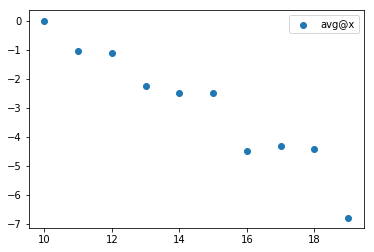

In [171]:
fig, ax = plt.subplots(1, 1)

lm = LinearRegression()
lm.fit(curve.index.values.reshape(-1,1), curve.values)
print(lm.coef_[0])

ax.scatter(curve.index, curve-curve.iloc[0], label="avg@x")
px = np.linspace(min(curve.index),max(curve.index))
#ax.plot(px, px*lm.coef_[0] + lm.intercept_, color='orange', label=f"Slope {lm.coef_[0]:.3f}")
ax.legend()
plt.show()

# Try RF on combined X->(y-min(y)) combined from all leaves

In [268]:
df_raw = toy_weight_data(2000)
df = df_raw.copy()
catencoders = df_string_to_cat(df)
df_cat_to_catcode(df)
df['pregnant'] = df['pregnant'].astype(int)
X = df.drop('weight', axis=1)
y = df['weight']

X.head(5)

,ID,sex,pregnant,height,education
0,100,2,0,71.749702,12
1,101,2,0,69.616357,16
2,102,2,0,67.397893,15
3,103,2,0,68.253207,13
4,104,2,0,69.677892,11


In [357]:
colname = 'education'
targetname = 'weight'
ntrees = 30
min_samples_leaf=20
rf = RandomForestRegressor(n_estimators=ntrees,
                           min_samples_leaf=min_samples_leaf,
                           oob_score=False)
rf.fit(X.drop(colname,axis=1), y)

uniq_x = np.unique(X[colname])

deltas = pd.DataFrame(index=uniq_x)
deltas.index.name = colname
print(deltas)

allx = []
ally = []
leaves = leaf_samples(rf, X.drop(colname, axis=1))
ci = 0
for samples in leaves:
    one_leaf_samples = X.iloc[samples]
    leaf_x = one_leaf_samples[colname].values
    leaf_y = y.iloc[samples].values
    min_idx = np.argmin(leaf_y)
    baseline = leaf_y[min_idx]#np.min(leaf_y)
    leaf_y -= baseline
    # kill the 0 baseline value (like a pivot in logistic regression)
#     print(leaf_y)
    leaf_x = np.delete(leaf_x, min_idx)
    leaf_y = np.delete(leaf_y, min_idx) 
    allx.extend(leaf_x)
    ally.extend(leaf_y)
    ci += 1

allx = np.array(allx)
ally = np.array(ally)
# curve = deltas.mean(skipna=True, axis=1)
df = pd.DataFrame(np.stack([allx, ally], axis=1), columns=[colname,targetname])
X_ = df[[colname]]
y_ = df[targetname]
df.head(10)

Empty DataFrame
Columns: []
Index: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


,education,weight
0,19.0,0.115415
1,14.0,10.298032
2,14.0,6.908034
3,19.0,4.191732
4,13.0,11.217660
5,17.0,2.444106
6,17.0,6.180728
7,18.0,5.471154
8,19.0,2.868678
9,14.0,8.505618


In [358]:
df.groupby(colname).mean() # actually this is all we need to compute avg value at each x

,weight
education,
10.0,10.507999
11.0,9.448216
12.0,9.216635
13.0,8.064197
14.0,7.084980
15.0,6.096334
16.0,4.923947
17.0,4.062881
18.0,3.819836


I don't think we need to create a decision tree to partition. grouping by then avg would work same same. just smaller partitions I guess

In [318]:
t = DecisionTreeRegressor()
t.fit(X_, y_)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [319]:
def dtree_leaf_samples(dtree, X:np.ndarray):
    leaf_ids = t.apply(X)
    d = pd.DataFrame(leaf_ids, columns=['leafid'])
    d = d.reset_index() # get 0..n-1 as column called index so we can do groupby
    sample_idxs_in_leaf = d.groupby('leafid')['index'].apply(lambda x: x.values)
    return sample_idxs_in_leaf

In [320]:
dtree_leaf_samples(t, X_[[colname]])

leafid
3     [25, 83, 84, 86, 91, 100, 102, 103, 104, 117, ...
5     [90, 109, 110, 113, 115, 233, 253, 291, 372, 3...
6     [11, 22, 28, 36, 71, 80, 81, 111, 120, 121, 14...
8     [9, 31, 35, 40, 44, 65, 82, 94, 95, 99, 101, 1...
9     [5, 7, 10, 16, 18, 26, 29, 45, 47, 52, 56, 57,...
12    [2, 3, 6, 21, 38, 58, 62, 63, 78, 79, 93, 97, ...
13    [12, 13, 14, 23, 24, 27, 50, 87, 98, 112, 140,...
16    [1, 32, 53, 54, 55, 61, 75, 76, 85, 88, 96, 10...
17    [8, 17, 20, 34, 37, 39, 41, 43, 46, 59, 64, 66...
18    [0, 4, 15, 19, 30, 33, 42, 48, 49, 51, 60, 69,...
Name: index, dtype: object

In [367]:
px = []
py = []

for tl in dtree_leaf_samples(t, X_[[colname]]):
    one_leaf_samples = X_.iloc[tl]
    leaf_x = one_leaf_samples[colname]#.values
    leaf_y = y_[tl]
#     print(np.mean(leaf_x), '->', np.mean(leaf_y),'->', np.stack([leaf_x, leaf_y], axis=1))
    lm = LinearRegression()
    lm.fit(leaf_x.values.reshape(-1,1), leaf_y.values)
#     print(f"Slope {lm.coef_[0]:.3f}")
    # this assume unique value in leaf_x really or merging of all leaf x values; just for experimentation
    px.append(np.mean(leaf_x))
#     leaf_y = t.predict(leaf_x.values.reshape(-1,1)) # same as mean really
    py.append(np.mean(leaf_y))
#     print(np.stack([leaf_x, leaf_y], axis=1))
#     Xy = pd.concat([leaf_x, leaf_y], axis=1)
#     print(Xy)


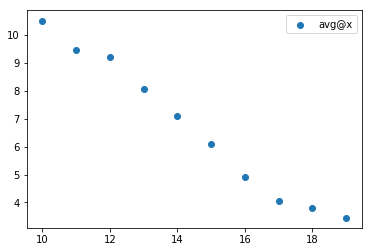

In [363]:
fig, ax = plt.subplots(1, 1)

ax.scatter(px, py, label="avg@x")

ax.legend()
plt.show()